In [1]:
import os
import pyaudio
import wave
from tensorflow import keras
import matplotlib.pyplot as plt
import  numpy as np
import time

In [2]:
p = pyaudio.PyAudio()
for i in range(p.get_device_count()):
    print(p.get_device_info_by_index(i))


{'index': 0, 'structVersion': 2, 'name': 'HDA NVidia: HDMI 0 (hw:0,3)', 'hostApi': 0, 'maxInputChannels': 0, 'maxOutputChannels': 8, 'defaultLowInputLatency': -1.0, 'defaultLowOutputLatency': 0.005804988662131519, 'defaultHighInputLatency': -1.0, 'defaultHighOutputLatency': 0.034829931972789115, 'defaultSampleRate': 44100.0}
{'index': 1, 'structVersion': 2, 'name': 'HDA NVidia: HDMI 1 (hw:0,7)', 'hostApi': 0, 'maxInputChannels': 0, 'maxOutputChannels': 8, 'defaultLowInputLatency': -1.0, 'defaultLowOutputLatency': 0.005804988662131519, 'defaultHighInputLatency': -1.0, 'defaultHighOutputLatency': 0.034829931972789115, 'defaultSampleRate': 44100.0}
{'index': 2, 'structVersion': 2, 'name': 'HDA NVidia: HDMI 3 (hw:0,9)', 'hostApi': 0, 'maxInputChannels': 0, 'maxOutputChannels': 8, 'defaultLowInputLatency': -1.0, 'defaultLowOutputLatency': 0.005804988662131519, 'defaultHighInputLatency': -1.0, 'defaultHighOutputLatency': 0.034829931972789115, 'defaultSampleRate': 44100.0}
{'index': 3, 'struc

In [7]:
SPEAKERS = p.get_host_api_info_by_index(4) #The modified part

OSError: [Errno -9978] Invalid host api info

In [ ]:
p = pyaudio.PyAudio()

info = p.get_host_api_info_by_index(0)
numdevices = info.get('deviceCount')
for i in range (0,numdevices):
        if p.get_device_info_by_host_api_device_index(0,i).get('maxInputChannels')>0:
                print("Input Device id ", i, " - ", p.get_device_info_by_host_api_device_index(0,i).get('name'))

        if p.get_device_info_by_host_api_device_index(0,i).get('maxOutputChannels')>0:
                print("Output Device id ", i, " - ", p.get_device_info_by_host_api_device_index(0,i).get('name'))


In [ ]:
files = os.listdir("/home/andrea/Scrivania/MIVIA_ROAD_DB1/noised_dataset/")
for i,f in enumerate(files):
    files[i] = "/home/andrea/Scrivania/MIVIA_ROAD_DB1/noised_dataset/"+f

In [6]:
from pydub import AudioSegment

#audio = AudioSegment.from_file("/home/andrea/Scrivania/audio_only.wav").get_array_of_samples()


MODEL TEST

In [2]:

#model = keras.models.load_model("audio_model_bidirectional_LSTM_overlap.h5")

dataset = np.load("/media/andrea/My Passport/splitted_ds_v2/fold3/train_ds.npy")
std_dev = np.std(dataset)
mean = np.mean(dataset)
maximum = np.max(dataset)
min = np.min(dataset)
scale = max(maximum, abs(min))

def normalize(array, std_dev, mean, scale):
    array = array/scale
    return array-mean/std_dev

In [3]:
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100

In [7]:
SPEAKERS = p.get_default_output_device_info()["hostApi"] #The modified part
frames = []
do_prediction = False
window = np.zeros((1,32,16516))
filled = 0
p = pyaudio.PyAudio()
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                input_host_api_specific_stream_info=SPEAKERS,
                frames_per_buffer=CHUNK)
add = False
start = time.time()

while True:
    st1 = time.time()
    data = stream.read(CHUNK,exception_on_overflow = False)
    frames.append(data)
    if CHUNK*len(frames) == 16384:

        s_arr = np.zeros((1,1,16516), dtype=np.int16)
        s_arr[0,0,:16384] = np.frombuffer(b''.join(frames), dtype=np.int16)
        del frames[:int(CHUNK/2*len(frames))]
        add = True
    if filled <= 31 and add:
        window[0,filled,:] = normalize(s_arr[0,0,:], std_dev, mean, scale)
        filled += 1

    elif filled > 31 and add:
        window = np.hstack((np.delete(window, 0, 1), normalize(s_arr, std_dev, mean, scale)))
        print("Full Window")
        do_prediction = True
    add = False
    if do_prediction:
        c = np.argmax(model.predict(window), axis=-1)
        #do_prediction = False
        print(c)

Full Window
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
Full Window
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
Full Window
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
Full Window
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
Full Window
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
Full Window
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
Full Window
[[0]]


KeyboardInterrupt: 

In [31]:
stream.stop_stream()
stream.close()
p.terminate()

MATRIX TEST

In [7]:
array = np.random.randint(100, size=(1,16,16516))

In [8]:
array_post = (np.delete(array, 0, 1))

In [8]:
start = time.time()
model.predict_classes(window)
print("Inference Time: " +str(time.time()-start))

Inference Time: 0.08124518394470215


In [ ]:
model.evaluate()

FAKE CHECKER

In [5]:
RECORD_SECONDS = 25

SPEAKERS = p.get_default_output_device_info()["hostApi"] #The modified part
frames = []
windows = []
filled = 0
p = pyaudio.PyAudio()
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                input_host_api_specific_stream_info=SPEAKERS,
                frames_per_buffer=CHUNK)

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS) + 1):
    data = stream.read(CHUNK)
    frames.append(data)
    '''
    if CHUNK*len(frames) == 16384:

        s_arr = np.zeros((1,1,16516))
        s_arr[0,0,:16384] = np.frombuffer(b''.join(frames), dtype=np.int16)
        frames = []
        windows.append(s_arr)
    '''

In [15]:
np.save("/home/andrea/Scrivania/bytes.npy", frames)

In [3]:
frames = np.load("/home/andrea/Scrivania/bytes.npy")
frames = frames[:1024]
samples = np.frombuffer(b''.join(frames), dtype=np.int16)

In [4]:
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)
from pydub import AudioSegment
audio = AudioSegment(samples,
                     frame_rate=44100,
                     sample_width=4,
                     channels=1)
audio = match_target_amplitude(audio, -20.0)

In [5]:
data = np.frombuffer(audio.raw_data, dtype=np.int16)

In [6]:
limit = int(len(data)/8258)*8258
test_data = data[:limit]

In [8]:
fake_ds = []

for j in range(len(sliding_windows)-32):
    fake_ds.append(sliding_windows[j:j+32])

In [9]:
np_ds = np.asarray(fake_ds)

In [11]:
model = keras.models.load_model("/media/andrea/My Passport/splitted_ds_v2/fold1/model1.h5")
model.predict_classes(normalize(np_ds, std_dev, mean, scale))

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [28]:
m1 = np.max(np.asarray(audio))
m2 = np.max(np_ds)

In [14]:
RECORD_SECONDS = 10

SPEAKERS = p.get_default_output_device_info()["hostApi"] #The modified part
frames = []
windows = []
filled = 0
p = pyaudio.PyAudio()
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                input_host_api_specific_stream_info=SPEAKERS,
                frames_per_buffer=CHUNK)

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS) + 1):
    data = stream.read(CHUNK)
    frames.append(data)

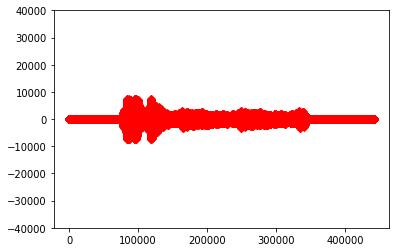

In [15]:
import numpy as np
data2 = np.frombuffer(b''.join(frames), dtype=np.int16)
plt.figure()
plt.ylim(-40000, 40000)
plt.plot(list(range(len(data2))), data2, '-gD',label='recorded', c='red')
plt.show()

In [16]:
def get_truck(audio_data):
    start = np.inf
    end = 0
    for index, n in enumerate(audio_data):
        if n!=0 and start > index:
            start = index
        if n!=0 and end < index:
            end = index
    return  start, end

start, end = get_truck(data2)

In [17]:
extracted = data2[start:end]

In [10]:
from pydub import AudioSegment
#new_audio = AudioSegment(extracted.tobytes(), sample_width=4, channels=1, frame_rate=44100)

In [11]:
wav_file = AudioSegment.from_wav("/home/andrea/Scrivania/MIVIA_ROAD_DB1/noised_ds_vol_norm/75.wav")

In [12]:
wav_file = np.frombuffer(wav_file.raw_data, dtype=np.int16)

In [56]:
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

restore = AudioSegment(extracted[:264256].tobytes(), channels=1, frame_rate=44100, sample_width=4)
restored = match_target_amplitude(restore, wav_file.)

In [57]:
data3 = np.frombuffer(restored.raw_data, dtype=np.int16)

In [32]:
def scale_data(data):
    m = max(data)
    ratio = 32767/m
    return (data*ratio).astype(np.int16)

In [ ]:
import matplotlib.pyplot as plt
x1 = list(range(len(extracted)))
x2 = list(range(len(wav_file)))



plt.figure()
plt.subplot(211)
plt.ylim(-40000, 40000)
plt.plot(x2, scale(extracted[:264256]), '-gD',label='recorded', c='red')

plt.subplot(212)
plt.ylim(-40000, 40000)
plt.plot(x2, wav_file[:264256],'-gD', label='acquired', c='blue')

plt.legend()
plt.show()

In [9]:
def process(audio_data):
    step = 16516
    half_step = int(step/2)
    fake_audio = np.zeros((1,32,16516), dtype=np.int16)
    for j in range(int(264256/half_step)-1):
        fake_audio[0,j,:] = audio_data[j*half_step:((j*half_step)+step)]
    fake_audio = normalize(fake_audio,std_dev, mean, scale)
    return fake_audio

In [79]:
recorded = process(extracted)
acquired = process(wav_file)

In [4]:
import pickle as pk
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.svm import OneClassSVM
labels = np.load("/media/andrea/My Passport/splitted_ds_v2/fold3/train_labels.npy")
pca = sklearnPCA(n_components=2)
transformed = pca.fit_transform(half_model.predict(normalize(dataset, std_dev, mean, scale)))
clf = OneClassSVM(gamma='scale',kernel='rbf', nu=0.0008, degree=120).fit(transformed[labels==1])

In [57]:
del pca, clf

In [12]:
def inference(data):
    interm = half_model.predict(data)
    int2 = pca.transform(interm)
    preds = clf.predict(int2)
    print(preds)
    return preds
inference(recorded)
inference(acquired)

NameError: name 'recorded' is not defined

In [65]:
processed = normalize(dataset, std_dev, mean, scale)
preds = inference(processed)

[-1 -1 -1 -1 -1 -1  1 -1  1 -1 -1  1 -1  1  1  1  1 -1  1  1  1 -1  1  1
  1  1  1 -1 -1  1 -1 -1  1  1 -1  1 -1  1  1 -1  1  1 -1 -1  1  1  1  1
  1  1 -1  1  1 -1  1  1 -1  1 -1 -1 -1  1 -1 -1  1 -1 -1  1  1 -1  1  1
  1  1  1  1  1  1  1  1  1  1 -1  1 -1  1  1 -1  1  1  1  1  1  1  1  1
 -1  1 -1 -1  1 -1  1  1 -1  1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1
  1 -1 -1  1  1 -1 -1  1  1  1 -1 -1  1 -1 -1 -1  1 -1 -1  1  1 -1  1  1
  1  1  1  1 -1  1  1 -1  1  1 -1 -1  1  1 -1  1 -1 -1 -1  1 -1 -1  1 -1
  1  1  1 -1  1 -1  1 -1  1  1 -1  1  1  1 -1  1  1 -1  1 -1 -1  1 -1 -1
  1 -1 -1  1  1  1  1 -1 -1  1  1 -1  1 -1  1 -1 -1  1 -1  1 -1 -1  1 -1
  1  1  1  1 -1 -1  1  1 -1  1  1  1 -1 -1  1 -1  1  1 -1  1  1 -1 -1  1
  1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1  1 -1  1 -1 -1  1  1 -1  1  1  1  1
  1  1  1 -1 -1 -1 -1  1  1 -1  1  1  1 -1  1 -1  1 -1 -1  1 -1 -1 -1  1
  1  1 -1 -1 -1  1 -1  1  1  1 -1  1 -1 -1  1 -1 -1 -1  1 -1 -1  1  1 -1
 -1  1 -1  1 -1  1  1  1  1 -1 -1 -1  1 -1  1 -1  1

In [66]:
labels = np.load("/media/andrea/My Passport/splitted_ds_v2/fold3/train_labels.npy")
labels[labels==0] = -1
(preds == labels).sum()/len(labels)

0.9955156950672646

In [3]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer, GRU, LSTMCell, RNN, Bidirectional
from tensorflow import keras
from tensorflow.keras import  regularizers
model_full = keras.models.load_model("/media/andrea/My Passport/splitted_ds_v2/fold3/model1.h5")
input_shape=(32,16516)
half_model = keras.Sequential()
half_model.add(InputLayer(input_shape=input_shape))
half_model.add(Dense(4096, activation='relu'))
half_model.add(Dropout(0.2))
half_model.add(Dense(2048, activation='relu'))
half_model.add(Dropout(0.2))
half_model.add(Dense(1024, activation='relu'))
half_model.add(Dropout(0.2))
half_model.add(Dense(512, activation='relu'))
half_model.add(Dropout(0.2))
half_model.add(Dense(256, activation='relu'))
half_model.add(Dropout(0.2))
half_model.add(Bidirectional(LSTM(192, input_shape=(32,256),
                                     kernel_regularizer=regularizers.l2(0.00001),
                                         recurrent_regularizer=regularizers.l2(0.00001),
                                         bias_regularizer=regularizers.l2(0.00001),
                                     recurrent_dropout=0.3)))
half_model.add(Dropout(0.4))
half_model.add(Dense(128, activation='relu'))

layer_num = 18
weigths_full = model_full.get_weights()
half_weigths = weigths_full[:layer_num]

half_model.set_weights(half_weigths)

In [23]:
import os
bin_lab = np.load("/home/andrea/Scrivania/MIVIA_ROAD_DB1/bin_classes.npy")
fds_lab = []
path = "/home/andrea/Scrivania/MIVIA_ROAD_DB1/noised_ds_vol_norm/"
list_f = sorted(os.listdir(path))
files = []
for file in list_f:
    files.append(np.frombuffer(AudioSegment.from_wav(path+file).raw_data, dtype=np.int16))
    l = int(file.split(".")[0])
    fds_lab.append(bin_lab[l])

In [16]:
preds = []
for f in files:
    temp = process(f)
    preds.append(inference(temp)[0])

[1]
[-1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[-1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[-1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[-1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[-1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[-1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[-1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[-1]
[1]
[1]
[1]
[1]
[-1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[-1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1

In [15]:
preds = preds.tolist()

AttributeError: 'list' object has no attribute 'tolist'

In [24]:
fds_lab= np.asarray(fds_lab)
fds_lab[fds_lab==0] = -1

In [26]:
((np.asarray(preds) == np.asarray(fds_lab)).sum())/742

0.9690026954177897

In [77]:
ds1 = np.load("/home/andrea/Scrivania/MIVIA_ROAD_DB1/dataset.npy")
ds2 = np.load("dataset_overlap.npy")
audio1 = np.frombuffer(AudioSegment.from_wav("/home/andrea/Scrivania/MIVIA_ROAD_DB1/noised_ds_vol_norm/1.wav").raw_data, dtype=np.int16)